In [1]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Read recipe inputs
titanic_train = dataiku.Dataset("titanic_train")
titanic_train_df = titanic_train.get_dataframe()
titanic_test = dataiku.Dataset("titanic_test")
titanic_test_df = titanic_test.get_dataframe()
titanic_testy = dataiku.Dataset("gender_submission")
titanic_testy_df = titanic_testy.get_dataframe()

print(titanic_train_df.columns)
print(titanic_test_df.columns)
print(titanic_testy_df.columns)

# Data Cleansing
titanic_train_df.fillna(0,inplace=True)
titanic_test_df.fillna(0,inplace=True)
titanic_testy_df.fillna(0,inplace=True)

print(titanic_train_df.isnull().any())
print(titanic_test_df.isnull().any())
print(titanic_testy_df.isnull().any())

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'], dtype='object')
Index([u'PassengerId', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'], dtype='object')
Index([u'PassengerId', u'Survived'], dtype='object')
PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool
PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool
PassengerId    False
Survived       False
dtype: bool


In [3]:
# Create X and y train datasets
X_train = titanic_train_df.drop(['Survived'],axis=1)
y_train = titanic_train_df[['Survived']]
X_train.shape,y_train.shape

# Create X and y test datasets
X_test = titanic_test_df
y_test = titanic_testy_df

In [89]:
#test = pd.merge(X_test, y_test, on='PassengerId', how='inner')

In [4]:
y_test = titanic_testy_df.drop(['PassengerId'],axis=1)
X_test.shape ,y_test.shape

((418, 11), (418, 1))

In [5]:
# Filter relevant features
feature_names = [ 'Pclass', 'Sex', 'Age', 'SibSp'
                , 'Parch', 'Fare']

X_train = X_train[feature_names]
X_test = X_test[feature_names]

# Convert categorical variable into numerical indicator variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train.shape,y_train.shape, X_test.shape, y_test.shape

((891, 7), (891, 1), (418, 7), (418, 1))

#### Building the Neural Network

In [6]:
def neural_network(hidden_nodes, num_iters):

    # Reset the graph
    tf.reset_default_graph()
    
    # Placeholders for input and output data
    n_input = X_train.shape[0]
    n_classes = y_train.shape[0]

    X = tf.placeholder(shape=(n_input, 7), dtype=tf.float32, name='X')
    y = tf.placeholder(shape=(n_classes, 1), dtype=tf.float32, name='y')    
    
    # Declare weights connecting the input to the hidden layer
    W1 = tf.Variable(tf.random_normal([7, hidden_nodes], stddev=0.03), name='W1')   #weights
    b1 = tf.Variable(tf.random_normal([hidden_nodes]), name='b1')    #bias

    W2 = tf.Variable(tf.random_normal([hidden_nodes, 1], stddev=0.03), name='W2')
    b2 = tf.Variable(tf.random_normal([1]), name='b2')    
    
    
    # Activation functions
    # Forward propagation
    hidden_out = tf.add(tf.matmul(X, W1), b1)
    A1 = tf.sigmoid(hidden_out)    # hidden layer output
    y_est = tf.sigmoid(tf.add(tf.matmul(A1, W2), b2))   # y predicted after hidden layer
    prediction = y_est
    
    # Define a loss function
    deltas = tf.square(y_est - y)
    loss = tf.reduce_sum(deltas)
    
    # Define a train operation to minimize the loss
    learning_rate=0.005
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005).minimize(loss)

    # Initialize variables and run session
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    # Go through num_iters iterations
    for i in range(num_iters):
        sess.run(optimizer, feed_dict={X: X_train, y: y_train})
        loss_plot[hidden_nodes].append(sess.run(loss, feed_dict={X: X_train.as_matrix(), y: y_train.as_matrix()}))
        weights1 = sess.run(W1)
        weights2 = sess.run(W2)
        be1 = sess.run(b1)
        be2 = sess.run(b2)
    
    print("loss (hidden nodes: %d, iterations: %d): %.2f" % (hidden_nodes, num_iters, loss_plot[hidden_nodes][-1]))
    sess.close()
    return weights1, weights2, be1, be2#, prediction,loss,optimizer

In [8]:
#hidden_nodes = 20
loss_plot = {5: [], 10: [], 20: []}
num_iters = 20000
weights1 = {5: None, 10: None, 20: None}
weights2 = {5: None, 10: None, 20: None}
be1 = {5: None, 10: None, 20: None}
be2 = {5: None, 10: None, 20: None}

loss (hidden nodes: 5, iterations: 20000): 150.00
loss (hidden nodes: 10, iterations: 20000): 128.63
loss (hidden nodes: 20, iterations: 20000): 109.46


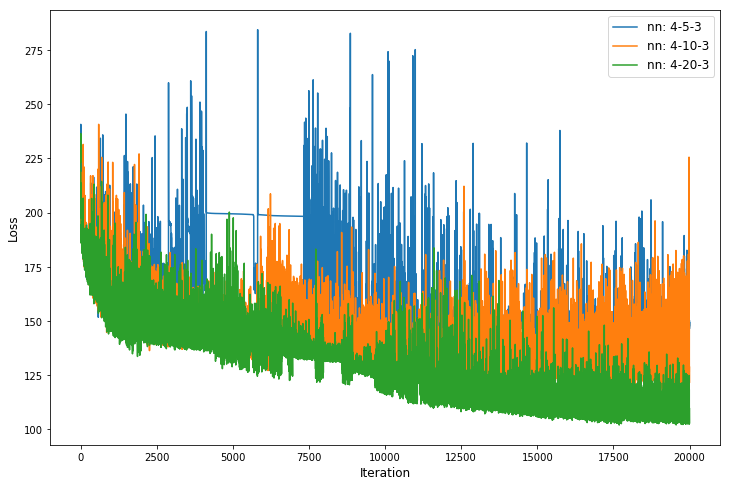

In [9]:
num_hidden_nodes = [5, 10, 20]
plt.figure(figsize=(12,8))
for hidden_nodes in num_hidden_nodes:
    weights1[hidden_nodes], weights2[hidden_nodes], be1[hidden_nodes], be2[hidden_nodes] = neural_network(hidden_nodes, num_iters)
    plt.plot(range(num_iters), loss_plot[hidden_nodes], label="nn: 4-%d-3" % hidden_nodes)
    
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)

In [90]:
# Evaluate models on the test set
X = tf.placeholder(shape=(418, 7), dtype=tf.float32, name='X')
y = tf.placeholder(shape=(418, 1), dtype=tf.float32, name='y')

for hidden_nodes in num_hidden_nodes:

    # Forward propagation
    W1 = tf.Variable(weights1[hidden_nodes])
    W2 = tf.Variable(weights2[hidden_nodes])

    b1 = tf.Variable(be1[hidden_nodes])
    b2 = tf.Variable(be2[hidden_nodes])

    # Activation functions
    A1 = tf.sigmoid(tf.add(tf.matmul(X, W1), b1))
    y_est = tf.sigmoid(tf.add(tf.matmul(A1, W2), b2)) 
   
    # Calculate the predicted outputs
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        y_est_np = sess.run(y_est, feed_dict={X: X_test, y: y_test})

    # Calculate the prediction accuracy  
    y_final = (y_est_np > 0.5).astype(int)
    correct = [estimate == target 
               for estimate, target in zip(y_final, y_test.as_matrix())]
    accuracy = 100 * sum(correct) / len(correct)
    
    #correct_prediction = np.equal(np.argmax(y_est_np, axis=1), np.argmax(y_test, axis=1))
    #accuracy = np.mean(correct_prediction)
    
    print('Network architecture 4-%d-3, accuracy: %.2f%%' % (hidden_nodes, accuracy))

Network architecture 4-5-3, accuracy: 90.00%
Network architecture 4-10-3, accuracy: 83.00%
Network architecture 4-20-3, accuracy: 90.00%
